In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
from src.semester_project import load_results
from src.policy import jaccard_distance

In [3]:
results = load_results("experiments/results_1576839084.pickle")

In [4]:
def hamming_distance(A,B,p):
    a = np.zeros(p)
    b = np.zeros(p)
    a[list(A)] = 1
    b[list(B)] = 1
    return scipy.spatial.distance.hamming(a, b)

In [52]:
colorsa = ["#ff7878", "#ffbc78", "#ffff78", "#bcff78", "#78ffbc"]
colorsb = ["#f2ffc1", "#beffa4", "#8ff2af", "#14e3b4", "#00b2ad"]
markers = ["o", "*", "+"]
    
runs = len(results[0])
N = len(results[0][0])
    
no_ints = np.zeros((len(results), runs, N))
all_trajectories_jac = {}
all_trajectories_ham = {}
names = []
for k, policy_runs in enumerate(results):
    name = policy_runs[0][0].policy.name
    names.append(name)
    trajectories_jac = []
    trajectories_ham = []
    for i,run_results in enumerate(policy_runs):
        no_ints[k, i,:] = list(map(lambda result: len(result.interventions()), run_results))
        for result in run_results:
            estimates = list(map(lambda step: step[0], result.history[1::])) + [result.estimate]
            trajectory_jac = list(map(lambda estimate: jaccard_distance(result.case.truth, estimate), estimates))
            trajectory_ham = list(map(lambda estimate: hamming_distance(result.case.truth, estimate, result.case.sem.p), estimates))
            trajectories_jac.append(trajectory_jac)
            trajectories_ham.append(trajectory_ham)
    all_trajectories_jac[name] = trajectories_jac
    all_trajectories_ham[name] = trajectories_ham

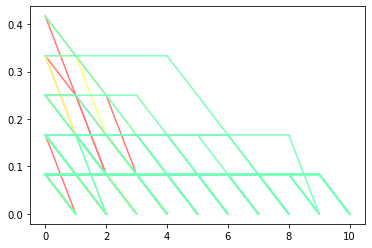

In [6]:
for i, (name, trajectories) in enumerate(all_trajectories_ham.items()):
    for trajectory in trajectories:
        plt.plot(trajectory, c=colors[i*2])

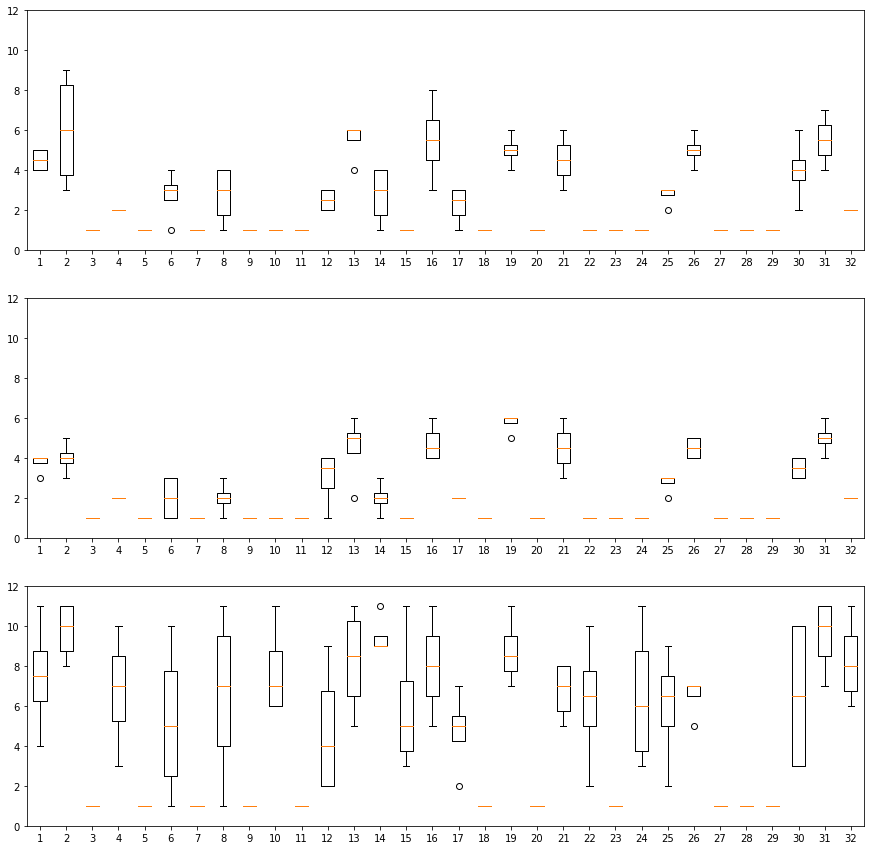

In [7]:
plt.figure(figsize=(15,15))
plt.subplot(311)
plt.boxplot(no_ints[0,:,:]), plt.ylim(0,12)
plt.subplot(312)
plt.boxplot(no_ints[1,:,:]), plt.ylim(0,12)
plt.subplot(313)
plt.boxplot(no_ints[2,:,:]), plt.ylim(0,12)
None

In [8]:
idx, = np.where(no_ints[0,:,:].mean(axis=0) > 1)
idx

array([ 0,  1,  3,  5,  7, 11, 12, 13, 15, 16, 18, 20, 24, 25, 29, 30, 31])

In [9]:
no_ints[0,:,idx].T.shape

(4, 17)

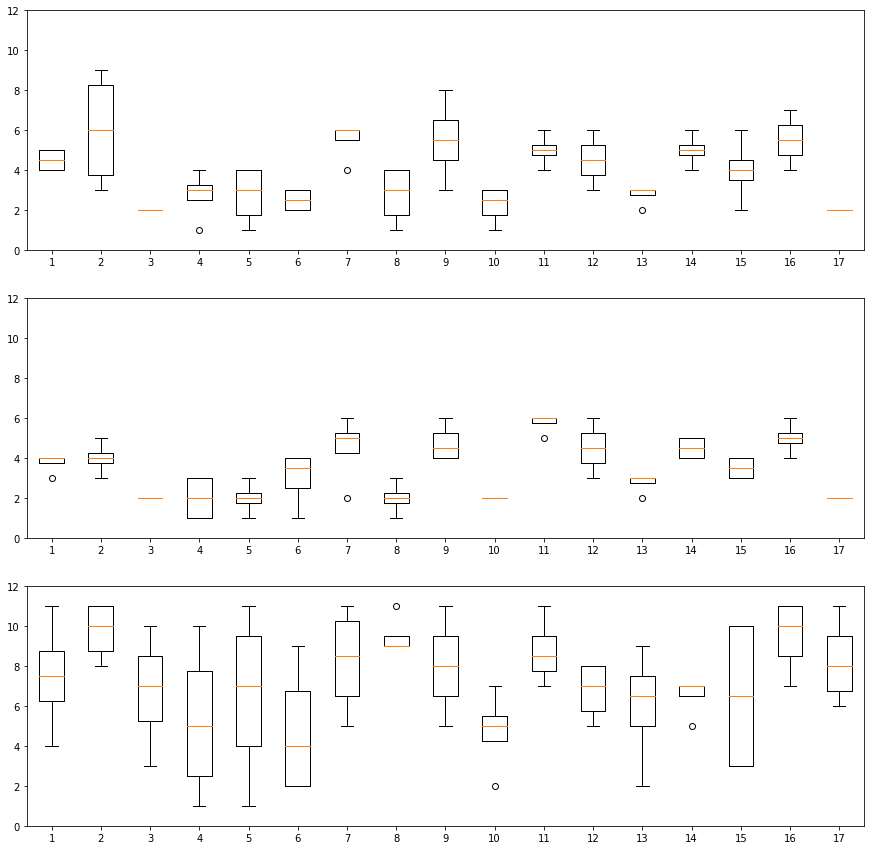

In [14]:
plt.figure(figsize=(15,15))
plt.subplot(311)
plt.boxplot(no_ints[0,:,idx].T), plt.ylim(0,12)
plt.subplot(312)
plt.boxplot(no_ints[1,:,idx].T), plt.ylim(0,12)
plt.subplot(313)
plt.boxplot(no_ints[2,:,idx].T), plt.ylim(0,12)
None

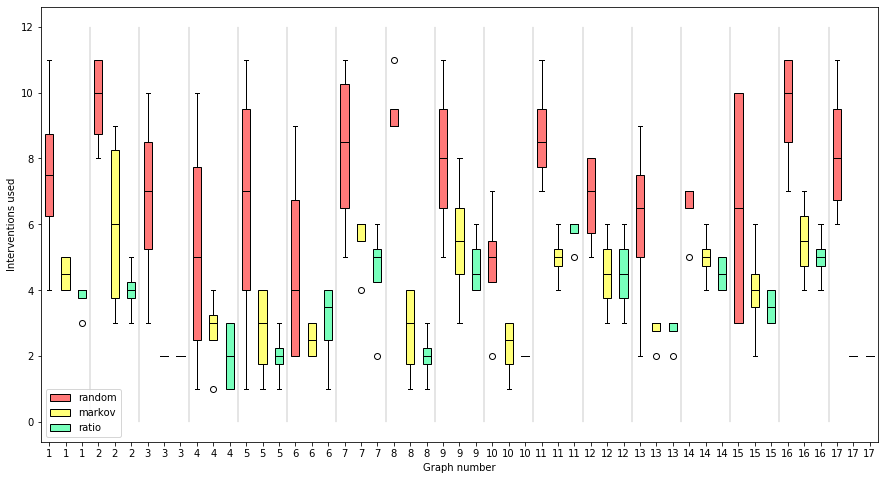

In [94]:
all_data = np.zeros((4,17*3))
all_data[:, 0:17*3:3] = no_ints[2,:,idx].T
all_data[:, 1:17*3:3] = no_ints[0,:,idx].T
all_data[:, 2:17*3:3] = no_ints[1,:,idx].T
labels = (np.floor(np.arange(0,17*3) / 3) + 1).astype(int)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
bplot = axes.boxplot(all_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,
                     medianprops = {'color': 'black'},
                     labels = labels)
for i,patch in enumerate(bplot['boxes']):
    patch.set_facecolor(colorsa[(i % 3*2)])
plt.xlabel("Graph number")
plt.ylabel("Interventions used")
plt.legend(bplot['boxes'][0:3], ['random', 'markov', 'ratio']);
for i in range(17):
    x = i*3+0.5
    plt.plot([x,x], [0,12], c='black', LineWidth=0.2)

In [76]:
(np.floor(np.arange(0,17*3) / 3) + 1).astype(int)

array([ 1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,  6,  6,
        6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11, 12,
       12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17])